In [1]:
using PyPlot
using Printf
using HDF5 
using LinearAlgebra, Random, Distributions
using Dates, Crayons
using Revise
using SparseArrays
using Parameters
using Interpolations
using DataFrames

using VQE

In [2]:
function energies_and_bitstrings_qaoa(annealing_problem)
    L = annealing_problem.num_qubits
    h = annealing_problem.local_fields
    J = annealing_problem.couplings
    
    bit_string_df = DataFrame( bit_string = [], energy = Float64[]);
    
    bitstrings = [string(i, base=2, pad=L) |> reverse for i in 0:(2^L - 1)]
    bitvals = [parse.(Int, [bitstring[j] for j in 1:L]) for bitstring in bitstrings]
    spins = [1 .- 2s for s in bitvals]
    
    for spin in spins
        energy = sum([-h[l] * spin[l] for l in 1:L]) + sum([-J[i, j] * spin[i] * spin[j] for i in 1:L for j in (i+1):L])
        push!(bit_string_df,[ spin, energy])
    end
    
    return bit_string_df
end

energies_and_bitstrings_qaoa (generic function with 1 method)

In [28]:
N = 12

energy_state_index_all = 0
non_count_index = 0
index_all = []


# data path
PATH = raw"/home/ubuntu/aqc_GNN/MAX2SAT_data"
folder_name = PATH * @sprintf("//result_data//N_%i//", N);


pattern = r"optimized_GNN_instance_N_12_idx_(\d{4})\.h5"

instance_names = readdir(folder_name)

loop_var = 1
total_num_inst = 0

# data path for original 
PATH_t = raw"/home/ubuntu/MAX2SAT"

folder_name_t = PATH_t * @sprintf("//MAX2SATQuantumData//Mirkarimi_data//HDF5//")


for (k, instance_name) in enumerate(instance_names[loop_var+0:loop_var+49])

    global total_num_inst = k
    idx = match(pattern, instance_name)[1]

    idx = parse(Int64, idx)
    println("idx: ", idx)

    file_name = folder_name * @sprintf("optimized_GNN_instance_N_%i_idx_%04i.h5", N, idx)
    
    file_name_t = folder_name_t * @sprintf("max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.h5", idx, N, 3N)
    

    #gs_energy = h5read(file_name, "true_energy")           
    pred_energy = h5read(file_name, "true_energy")
    pred_spins = h5read(file_name, "pred_spins")
    #true_spins = h5read(file_name, "true_spins")          
    
    pred_spins = rounded = ceil.(Int, pred_spins)
    #println(pred_spins)


    local_fields = h5read(file_name_t, "local_fields")
    J_mat = h5read(file_name_t, "coupling_matrix")

    mf_problem = Problem(0, - local_fields, J_mat);

    
    exact_solution_bitstring = energies_and_bitstrings_qaoa(mf_problem)
    sorted_df = sort(exact_solution_bitstring, :energy)
    
    lowest_energy_rows = sorted_df[1:20, :]
    lowest_energy = sorted_df[1, :] 
    
    #println(lowest_energy_rows)
    
    exact_bitstring = lowest_energy[1]
    #println(exact_bitstring)
    
    
    # find the energy of a bitstring  
    target_bitstring = pred_spins
    
    
    # Filter the DataFrame for the row containing the target bitstring
    matching_row = filter(row -> row.bit_string == target_bitstring, lowest_energy_rows)
    
    # Check if a match is found
    if nrow(matching_row) > 0
        #println("Matching bitstring found: ", matching_row)
        state_index = findfirst(row -> row[:bit_string] == target_bitstring, eachrow(lowest_energy_rows))
        state_index -= 1
        println(state_index)
        push!(index_all, copy(state_index)) 
        energy_state_index_all += state_index 
        #println(energy_state_index_all)
    else
        println("No matching bitstring found.")
        non_count_index += 1
    end
    

end

#println(total_num_inst)
average_state_index = energy_state_index_all / total_num_inst
println("average energy state index: ", average_state_index)

idx: 1
0
idx: 2
0
idx: 3
0
idx: 4
0
idx: 5
0
idx: 6
0
idx: 7
0
idx: 8
0
idx: 9
0
idx: 10
0
idx: 11
0
idx: 12
0
idx: 13
0
idx: 14
0
idx: 15
0
idx: 16
0
idx: 17
0
idx: 18
0
idx: 19
0
idx: 20
0
idx: 21
0
idx: 22
0
idx: 23
0
idx: 24
0
idx: 25
0
idx: 26
0
idx: 27
0
idx: 28
0
idx: 29
0
idx: 30
0
idx: 31
0
idx: 32
0
idx: 33
0
idx: 34
0
idx: 35
0
idx: 36
0
idx: 37
0
idx: 38
0
idx: 39
0
idx: 40
0
idx: 41
0
idx: 42
0
idx: 43
0
idx: 44
0
idx: 45
0
idx: 46
0
idx: 47
0
idx: 48
0
idx: 49
0
idx: 50
0
average energy state index: 0.0


50
[0]
[50]


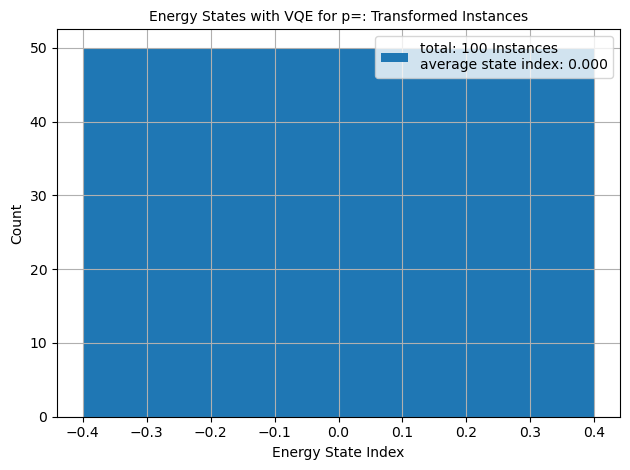

In [ ]:
println(length(index_all))

value_counts = Dict(x => count(==(x), index_all) for x in unique(index_all))

# Extract x (unique values) and y (counts) for the bar chart
x_values = collect(keys(value_counts))
y_counts = collect(values(value_counts))
println(x_values)
println(y_counts)

#figure(figsize=(7, 4))
fig,ax = subplots()

# Create the bar chart
ax.bar(x_values, y_counts, label = @sprintf("total: 100 Instances \naverage state index: %.3f", average_state_index))


ax.set_xlabel("Energy State Index")
ax.set_ylabel("Count")
ax.set_title("Energy States with VQE: Transformed Instances", fontsize=10)
ax.legend(loc="upper right", fontsize=10)
tight_layout()
grid(true)

display(gcf())